# 시계열 데이터(Time Series Data) 다루기

## II. 전염병 예측_V2[ 시계열 데이터 일반화]

- 문제 정의
  - 3일 동안의 확진자 수 추이를 보고 다음날의 확진자 수를 예측


```python
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
```

<details>
  <summary>Library</summary>



- from keras.models import Sequential
  - 케라스의 모델 도구(models)중 시퀀셜 모델을 불러오는 명령어
- from keras.layers import SimpleRNN, Dense, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D
  - 레이어 도구(layers)중 SimpleRNN과 Dense도구등을 불러오는 명령어
- from sklearn.prerprocessing import MinMaxSacler
  - 데이터를 정규화하기 위한 MinMaaxScaler 함수를 불러오는 명령어
- from sklearn.metrics import mean_squared_error
  - 결과의 정확도를 계산하기 위한 함수인 mean_squared_error를 불러오는 명령어
- from sklearn.model_selection import train_test_split
  - 데이터를 훈련데이터와 검증 데이터로 나누는 명령어
- import math
  - 수학 계산을 도와주는 math 라이브러리
- import numpy as np
  - 수학 계산 라이브러리 numpy를 불러오고 np로 줄여서 사용
- import matplotlib.pyplot as plt
  - 그래프 라이브러리중 pyplot 라이브러리 사용
  - plt로 줄여서 사용

</details>

In [1]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, GRU, LSTM, Bidirectional, Conv1D, MaxPooling1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

2023-05-14 16:01:35.307201: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 1. 데이터 불러오기

In [2]:
import os
print(os.getcwd())
os.chdir("/Users/ryu/Desktop/Desktop ryuseungho's MacBook Air/Data Scientist/Study_Organization/DeepLearning/RNN(LSTM,GRU)/Data")
print(os.getcwd())

/Users/ryu/Desktop/Desktop ryuseungho's MacBook Air/Data Scientist/Study_Organization/DeepLearning/RNN(LSTM,GRU)
/Users/ryu/Desktop/Desktop ryuseungho's MacBook Air/Data Scientist/Study_Organization/DeepLearning/RNN(LSTM,GRU)/Data


In [3]:
# github 저장소에서 데이터 불러오기
# !git clone https://github.com/yhlee1627/deeplearning.git
# git이 안될경우 주소에서 다운로드

df = pd.read_csv('./deeplearning/corona_daily.csv', usecols = [3], engine = 'python', skipfooter = 3)
dataframe = df.values
dataframe = df.astype('float32')

### 2. 데이터 전처리

#### 2-1. 데이터 분할
- 각 분할에 사용할 샘플 개수 계산
    - Train Data : 50%
    - Val Data : 25%
    - Test Data : 25%

In [4]:
train_samples_n = int(0.5 * len(df))
val_samples_n = int(0.25 * len(df))
test_samples_n = len(df) - train_samples_n - val_samples_n
print(f"Train Data 개수 : {train_samples_n}")
print(f"Val Data 개수 : {val_samples_n}")
print(f"Test Data 개수 : {test_samples_n}")

Train Data 개수 : 56
Val Data 개수 : 28
Test Data 개수 : 28


### 2-2. 데이터 정규화

In [5]:
df

,Confirmed
0,24
1,24
2,27
3,27
4,28
...,...
107,11190
108,11206
109,11225
110,11265


In [6]:
# 시계열은 스케일이 각각 다르므로 독립적으로 정규화(평균과 표준편차 사용)
mean = df[:train_samples_n].mean(axis = 0)
df -= mean
std = df[:train_samples_n].std(axis = 0)
df /= std

### 2-3. 시퀀스 데이터 준비 및 분할

- 3일치의 데이터를 사용하여 4번째 날짜의 값을 예측
<img src='https://p.ipic.vip/0wzzyd.png' width=50%>

- 과정

  - I. 현재 데이터의 시간 단위(1일)와 예측하려는 시간 단위 (1일)을 통일
    - $sampling\_rate = 1$
  - II. 사용할 데이터의 기간 정의(3일)
    - $sequenc\_length = 3$
  - III. 예측 시점 하루 뒤
    - $delay = sampling\_rate * (sequence\_length + 1 - 1)$

<img src='https://p.ipic.vip/cg3n6r.png'>

- timeseries_dataset_from_array() : 중복된 데이터 때문에 생기는 메모리 낭비를 줄여줌

<details>
<summary>Option</summary>



```python
tf.keras.utils.timeseries_dataset_from_array(
        data,
        targets,
        sampling_rate = 1,
			  sequence_length,
        delay = sampling_rate * (sequence_length + 24 - 1)      
        sequence_stride = 1,
        batch_size = 128,
        shuffle = Fasle,
        seed None,
        start_index = None,
        end_index = None
    )
```


| Option                       |              Explanation              |
| :--------------------------- | :-----------------------------------: |
| data                         |      타깃 데이터를 제외한 데이터      |
| targets                      |              타깃 데이터              |
| sampling_rate                |         시퀀스 데이터의 단위          |
| sequence_length              |  훈련에 사용할 시퀀스 데이터의 길이   |
| delay                        |         예측하고자 하는 시점          |
| sequence_stride(default = 1) |         연속 시계열 간의 거리         |
| batch_size(default = 128)    | 각 배치의 시계열 샘플 수(마지막 제외) |
| shuffle                      |        출력 샘플을 섞을지 말지        |
| seed                         |                고정값                 |
| start_index                  |   사용할 데이터의 시작 인덱스 위치    |
| end_index                    |    사용할 데이터의 끝 인덱스 위치     |

</details>

In [7]:
from tensorflow import keras

sampling_rate = 1  
sequence_length = 3                                    # 이전 3일의 데이터 사용
delay = sampling_rate * (sequence_length + 1 - 1)      # 하루 뒤 
batch_size = 54                                        # 이 데이터에 최대 batch_size = 54

# Training Data : 0 ~ train_samples_n
train_dataset = keras.utils.timeseries_dataset_from_array(
    df[:-delay],
    targets = df[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
#     shuffle = True,
    batch_size = batch_size,
    start_index = 0,
    end_index = train_samples_n
)

# Validation Data : train_samples_n ~ train_samples_n + val_samples_n
val_dataset = keras.utils.timeseries_dataset_from_array(
    df[:-delay],
    targets = df[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
#     shuffle = True,
    batch_size = batch_size,
    start_index = train_samples_n,
    end_index = train_samples_n + val_samples_n
)

# Test Data : train_samples_n + val_sampes_n + End
test_dataset = keras.utils.timeseries_dataset_from_array(
    df[:-delay],
    targets = df[delay:],
    sampling_rate = sampling_rate,
    sequence_length = sequence_length,
#     shuffle = True,
    batch_size = batch_size,
    start_index = train_samples_n + val_samples_n
)

2023-05-14 16:01:45.406085: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
for samples, targets in train_dataset:
    print(f"샘플 크기 : {samples.shape}")
    print(f"타깃 크기 : {targets.shape}")
    break

샘플 크기 : (54, 3, 1)
타깃 크기 : (54, 1)


### 3. 모델 정의

#### 3-1. 순환 신경망(RNN; Recurrent Neural Network)

- 순차적인 데이터(Sequence Data)를 처리하기 위한 인공 신경망
  - 어떤 특정 부분이 반복되는 구조에서 순서를 학습하기에 효과적
  - 시계열 데이터, 자연어 등에 적용 가능
  - 기존 Neural Network와 달리 '기억(Hidden State)'을 가지고 있음
  - 은닉 계층 안에 하나 이상의 순환 계층을 갖는 신경망 구조
    - 이전 단계의 출력 값이 현재 단계의 입력 값으로 다시 들어가는 반복 구조
    - 가중치가 모든 타임 스텝에서 공유됨


<details>
<summary>RNN Process</summary>



<img src='https://p.ipic.vip/2bdtgi.png'>

</details>

In [9]:
inputs = keras.Input(shape = (sequence_length, df.shape[-1]))
x = keras.layers.SimpleRNN(16, recurrent_dropout = 0.25)(inputs) 
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 1)]            0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 16)                288       
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________


####  3-2. LSTM ; Long Short Term Memory

- RNN 의 **장기의존성 문제**와 **기울기 소실 문제**를 해결한 알고리즘

  - 가중치 행렬 $W$의 행렬 곱 연산이 그레이디언트 경로에 나타나지 않도록 구조 변경

- 기존 RNN에 장기 기억 셀(Cell State)을 추가함

  - $c_t$를 연결하는 경로에는 가중치 행렬 $W$의 행렬 곱 연산이 없음

    <img src='https://p.ipic.vip/hiuty3.png' width=80%>

- 장기 기억 셀 연산에 사용되는 게이트 추가

  - Forget Gate($f_t$) : 과거의 정보를 얼마나 유지할 것인가?
  - Input Gate($i_t$) : 새로 입력된 정보를 얼만큼 활용할 것인가?
  - Output Gate($o_t$) : Cell State 나온 정보를 얼마나 출력할 것인가?

<details>
<summary>LSTM Process</summary>
<img src='https://p.ipic.vip/elqu30.png'>



</details>

In [10]:
inputs = keras.Input(shape = (sequence_length, df.shape[-1]))
x = keras.layers.LSTM(32, recurrent_dropout = 0.25)(inputs)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 3, 1)]            0         
                                                                 
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


#### 3-3. GRU ; Gated Recurrent Unit

- LSTM의 장점을 유지하면서 게이트 구조를 단순하게 만든 순환 신경망
  - 업데이트 게이트(Update Gate) = Forget Gate + Input Gate
    - 과거의 기억중 사용할 정보의 양과 현 시점의 입력 정보 중 사용할 정보 수집
  - 리셋 게이트(Reset Gate)
    - 현 시점의 입력 정보 중 새로운 정보를 추가할 때, 과거의 기억 중 필요한 정보의 양 계산
  - 장기 기억 셀(Cell State)을 삭제
    - 은닉 상태($h_{t-1}$)가 장기 기억과 단기 기억 모두를 기억하도록 함
  - 출력 게이트가 존재하지 않음
    - 전체 상태 벡터가 매 타임 스텝마다 출력

<details>
<summary>GRU Process</summary>
<img src='https://p.ipic.vip/6obmtd.png'>
</details>



In [11]:
inputs = keras.Input(shape = (sequence_length, df.shape[-1]))
x = keras.layers.GRU(32, recurrent_dropout = 0.25)(inputs)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 3, 1)]            0         
                                                                 
 gru (GRU)                   (None, 32)                3360      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________


#### 3-4. 양방향(Bidirectional) LSTM/GRU

- 양방향 순환 층(Bidirectional Recurrent Layer)
  - 순환 네트워크에 같은 정보를 다른 방향으로 주입하여 정확도를 높이고 기억을 좀 더 오래 유지
  - 이전의 층이 전체 출력 시퀀스를 반환해야 함 [ return_sequence = True ]

<details>
<summary>양방향 LSTM/GRU</summary>



In [12]:
inputs = keras.Input(shape = (sequence_length, df.shape[-1]))
x = keras.layers.Bidirectional(keras.layers.LSTM(16))(inputs)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 3, 1)]            0         
                                                                 
 bidirectional (Bidirectiona  (None, 32)               2304      
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,337
Trainable params: 2,337
Non-trainable params: 0
_________________________________________________________________


#### 3-5. 1D CNN + LSTM/GRU

<details>
<summary>1D CNN + LSTM/GRU</summary>
<img src='https://p.ipic.vip/bzx124.png'>
</details>

In [34]:
inputs = keras.Input(shape = (sequence_length, df.shape[-1]))
x = keras.layers.Conv1D(filters=32,
               kernel_size=1,
               strides=1,
               activation='relu')(inputs)
x = keras.layers.MaxPooling1D(pool_size = 3)(x)
x = keras.layers.LSTM(32, recurrent_dropout = 0.25)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 3, 1)]            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 3, 32)             64        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 32)            0         
 1D)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 8,417
Trainable params: 8,417
Non-trainable params: 0
_________________________________________________________

### 4. 모델 학습

In [37]:
model.compile(optimizer = 'rmsprop', loss = 'mse', metrics=['mae'])
history = model.fit(train_dataset,
                   epochs = 100,
                   validation_data = val_dataset)

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.0201 - mae: 0.1140 - val_loss: 0.0554 - val_mae: 0.2349
Epoch 2/100
1/1 [==============================] - 0s 52ms/step - loss: 0.0134 - mae: 0.0933 - val_loss: 0.0386 - val_mae: 0.1961
Epoch 3/100
1/1 [==============================] - 0s 48ms/step - loss: 0.0126 - mae: 0.0937 - val_loss: 0.0316 - val_mae: 0.1772
Epoch 4/100
1/1 [==============================] - 0s 45ms/step - loss: 0.0134 - mae: 0.0842 - val_loss: 0.0302 - val_mae: 0.1733
Epoch 5/100
1/1 [==============================] - 0s 49ms/step - loss: 0.0121 - mae: 0.0908 - val_loss: 0.0285 - val_mae: 0.1683
Epoch 6/100
1/1 [==============================] - 0s 48ms/step - loss: 0.0116 - mae: 0.0857 - val_loss: 0.0282 - val_mae: 0.1675
Epoch 7/100
1/1 [==============================] - 0s 52ms/step - loss: 0.0115 - mae: 0.0869 - val_loss: 0.0278 - val_mae: 0.1663
Epoch 8/100
1/1 [==============================] - 0s 48ms/step - loss: 0.0114 - mae: 0.0857

### 5. 고급 기법

#### 5-1. 스태킹 순환 층(Stacking Recurrent Layer) 


- 모델의 표현 능력(Representational Power)을 증가 시킴  

In [15]:
# 스태킹
inputs = keras.Input(shape = (sequence_length, df.shape[-1]))
x = keras.layers.GRU(32, return_sequences = True)(inputs)
x = keras.layers.GRU(32)(x)
x = keras.layers.Dense(1)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer = 'rmsprop', loss = 'mse',  metrics = ['mae'])
history = model.fit(train_dataset,
                   epochs = 100,
                   validation_data = val_dataset)

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 1.0992 - mae: 0.9836 - val_loss: 2.1423 - val_mae: 1.4632
Epoch 2/100
1/1 [==============================] - 0s 54ms/step - loss: 1.0211 - mae: 0.9462 - val_loss: 1.9958 - val_mae: 1.4123
Epoch 3/100
1/1 [==============================] - 0s 50ms/step - loss: 0.9689 - mae: 0.9203 - val_loss: 1.8757 - val_mae: 1.3691
Epoch 4/100
1/1 [==============================] - 0s 49ms/step - loss: 0.9255 - mae: 0.8983 - val_loss: 1.7681 - val_mae: 1.3293
Epoch 5/100
1/1 [==============================] - 0s 50ms/step - loss: 0.8861 - mae: 0.8778 - val_loss: 1.6672 - val_mae: 1.2908
Epoch 6/100
1/1 [==============================] - 0s 54ms/step - loss: 0.8488 - mae: 0.8579 - val_loss: 1.5703 - val_mae: 1.2527
Epoch 7/100
1/1 [==============================] - 0s 52ms/step - loss: 0.8123 - mae: 0.8380 - val_loss: 1.4761 - val_mae: 1.2146
Epoch 8/100
1/1 [==============================] - 0s 51ms/step - loss: 0.7762 - mae: 0.8180

#### 5-2. 순환 드롭아웃(Recurrent Dropout) 

- 드롭아웃의 한 종류로 순환 층에서 과대적합을 방지하기 위해 사용

- 조건 : 모든 중간층은 전체 출력 시퀀스를 반환해야 함 [return_sequence = True]

In [16]:
# 드롭아웃
inputs = keras.Input(shape = (sequence_length, df.shape[-1]))
x = keras.layers.GRU(32, recurrent_dropout = 0.25, return_sequences = True)(inputs)
x = keras.layers.GRU(32, recurrent_dropout = 0.25)(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer = 'rmsprop', loss = 'mse', metrics=['mae'])
history = model.fit(train_dataset,
                   epochs = 100,
                   validation_data = val_dataset)

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 1.3941 - mae: 1.1030 - val_loss: 2.4479 - val_mae: 1.5641
Epoch 2/100
1/1 [==============================] - 0s 50ms/step - loss: 1.1501 - mae: 1.0000 - val_loss: 2.1130 - val_mae: 1.4531
Epoch 3/100
1/1 [==============================] - 0s 48ms/step - loss: 1.0521 - mae: 0.9518 - val_loss: 1.8699 - val_mae: 1.3670
Epoch 4/100
1/1 [==============================] - 0s 50ms/step - loss: 0.9044 - mae: 0.8864 - val_loss: 1.6486 - val_mae: 1.2836
Epoch 5/100
1/1 [==============================] - 0s 49ms/step - loss: 0.8522 - mae: 0.8540 - val_loss: 1.4573 - val_mae: 1.2068
Epoch 6/100
1/1 [==============================] - 0s 48ms/step - loss: 0.8103 - mae: 0.8300 - val_loss: 1.2914 - val_mae: 1.1360
Epoch 7/100
1/1 [==============================] - 0s 48ms/step - loss: 0.6853 - mae: 0.7623 - val_loss: 1.1363 - val_mae: 1.0656
Epoch 8/100
1/1 [==============================] - 0s 47ms/step - loss: 0.6613 - mae: 0.7459

#### 5-3. Early Stopping

- 너무 많은 Epoch는 Overfitting을 일으킨다
- 너무 적은 Epoch는 Underfitting을 일으킨다
- Epoch를 많이 돌린 후, 특정 시점에서 멈춤
  - monitor : 모델 학습을 멈추는 기준
  - patience : 최소 반복수
  - verbose : 자세한 정보 표시 모드 ( 0 or 1 )

In [28]:
# Early Stopping
from keras.callbacks import EarlyStopping

inputs = keras.Input(shape = (sequence_length, df.shape[-1]))
x = keras.layers.GRU(32, recurrent_dropout = 0.5, return_sequences = True)(inputs)
x = keras.layers.GRU(32, recurrent_dropout = 0.5)(x)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

model.compile(optimizer = 'rmsprop', loss = 'mse', metrics=['mae'])
history = model.fit(train_dataset,
                   epochs = 100,
                   validation_data = val_dataset,
                   callbacks = [early_stopping])

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 0.9084 - mae: 0.8887 - val_loss: 1.5987 - val_mae: 1.2640
Epoch 2/100
1/1 [==============================] - 0s 51ms/step - loss: 0.7540 - mae: 0.8074 - val_loss: 1.3442 - val_mae: 1.1591
Epoch 3/100
1/1 [==============================] - 0s 50ms/step - loss: 0.6517 - mae: 0.7481 - val_loss: 1.1566 - val_mae: 1.0751
Epoch 4/100
1/1 [==============================] - 0s 53ms/step - loss: 0.5947 - mae: 0.7128 - val_loss: 1.0057 - val_mae: 1.0025
Epoch 5/100
1/1 [==============================] - 0s 53ms/step - loss: 0.5408 - mae: 0.6724 - val_loss: 0.8727 - val_mae: 0.9339
Epoch 6/100
1/1 [==============================] - 0s 52ms/step - loss: 0.4438 - mae: 0.6075 - val_loss: 0.7563 - val_mae: 0.8694
Epoch 7/100
1/1 [==============================] - 0s 57ms/step - loss: 0.4189 - mae: 0.5907 - val_loss: 0.6498 - val_mae: 0.8059
Epoch 8/100
1/1 [==============================] - 0s 52ms/step - loss: 0.3529 - mae: 0.5386

### 6. 데이터 예측

In [47]:
# Dataset에서 samples과 target 분리
for train_samples, train_targets in train_dataset:
    pass
for val_samples, val_targets in val_dataset:
    pass
for test_samples, test_targets in test_dataset:
    pass

In [41]:
# 모델을 적용한 출력값
trainPredict = model.predict(train_samples)
valPredict = model.predict(val_samples)
testPredict = model.predict(test_samples)

# * std + mean을 통하여 실제 값으로 변환
# Training Data 예측값
Train_Predict = list()
for i in trainPredict:
    Train_Predict.append(i * std + mean)

# Training Data 타깃 값
Train_Targets = list()
for i in train_targets:
    Train_Targets.append(i * std + mean)
    
# Validation Data 예측값
Val_Predict = list()
for i in valPredict:
    Val_Predict.append(i * std + mean)

# Validation Data 타깃 
Val_Targets = list()
for i in val_targets:
    Val_Targets.append(i * std + mean)
    
# Test Data 예측값
Test_Predict = list()
for i in testPredict:
    Test_Predict.append(i * std + mean)
    
# Test Data 타깃값
Test_Targets = list()
for i in test_targets:
    Test_Targets.append(i * std + mean)

1/1 [==============================] - 0s 14ms/step


### 7. 모델의 정확도

In [42]:
trainScore = math.sqrt(mean_squared_error(Train_Targets, Train_Predict))
print(f"Train Score : {trainScore:.2f} RMSE")

valScore = math.sqrt(mean_squared_error(Val_Targets, Val_Predict))
print(f"Train Score : {valScore:.2f} RMSE")

testScore = math.sqrt(mean_squared_error(Test_Targets, Test_Predict))
print(f"Train Score : {testScore:.2f} RMSE")

Train Score : 255.92 RMSE
Train Score : 137.97 RMSE
Train Score : 180.13 RMSE


### 8. 시각화 실제 값과 예측값 그래프

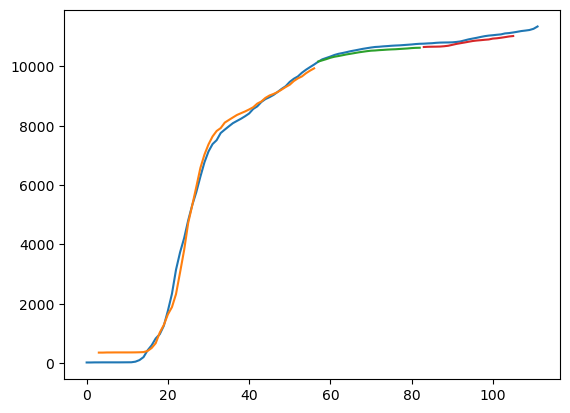

In [48]:
# train
trainPredictPlot = np.empty_like(dataframe)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[sequence_length:len(Train_Predict)+sequence_length, :] = Train_Predict
# val
valPredictPlot = np.empty_like(dataframe)
valPredictPlot[:, :] = np.nan
valPredictPlot[len(Train_Predict)+sequence_length :len(Train_Predict)+len(Val_Predict)+sequence_length, :] = Val_Predict
# test
testPredictPlot = np.empty_like(dataframe)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(Train_Predict)+len(Val_Predict)+ sequence_length : len(Train_Predict)+len(Val_Predict)+ sequence_length + len(Test_Predict), :] = Test_Predict

plt.plot(dataframe)               # 파란색 : 실제 값
plt.plot(trainPredictPlot)      # 주황색 : Training Data 예측값
plt.plot(valPredictPlot)        # 초록색 : Validation Data 예측값
plt.plot(testPredictPlot)       # 빨간색 : Test Data 예측값
plt.show()